# Tree algorithm
- 주로 분류와 회귀문제에 사용

## 와인 데이터 준비

In [1]:
import pandas as pd
wine=pd.read_csv('https://bit.ly/wine_csv_data')

wine.shape,wine.head()

((6497, 4),
    alcohol  sugar    pH  class
 0      9.4    1.9  3.51    0.0
 1      9.8    2.6  3.20    0.0
 2      9.8    2.3  3.26    0.0
 3      9.8    1.9  3.16    0.0
 4      9.4    1.9  3.51    0.0)

In [2]:
wine['class'].unique()  #0은 레드와인, 1은 화이트와인

array([0., 1.])

In [3]:
data=wine.iloc[:,:3].to_numpy()
answer=wine.iloc[:,3].to_numpy()
data[:10,:], answer[:10]

(array([[ 9.4 ,  1.9 ,  3.51],
        [ 9.8 ,  2.6 ,  3.2 ],
        [ 9.8 ,  2.3 ,  3.26],
        [ 9.8 ,  1.9 ,  3.16],
        [ 9.4 ,  1.9 ,  3.51],
        [ 9.4 ,  1.8 ,  3.51],
        [ 9.4 ,  1.6 ,  3.3 ],
        [10.  ,  1.2 ,  3.39],
        [ 9.5 ,  2.  ,  3.36],
        [10.5 ,  6.1 ,  3.35]]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [4]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_answer, test_answer=train_test_split(data,answer,test_size=0.2,random_state=1234)
train_data.shape, test_data.shape

((5197, 3), (1300, 3))

## (정규화는 사실 할 필요없음)

In [5]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
ss.fit(train_data)
train_data_scaled=ss.transform(train_data)
test_data_scaled=ss.transform(test_data)

## 로지스틱 회귀로 레드와인, 화이트와인 분류가능->but 대중들에게 설명 어려움

# 1. 결정트리(Decision Tree)
- 질문을 주고 if-else의 방식

In [6]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier(random_state=123)   #random_state존재 이유: 질문의 순서를 섞음
dt.fit(train_data_scaled,train_answer)
dt.score(train_data_scaled,train_answer), dt.score(test_data_scaled,test_answer) #과대적합이긴 하지만 훈련세트의 정확도는 매우 높음

(0.9976909755628247, 0.8607692307692307)

In [7]:
# 로지스틱 회귀와 비교
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(train_data_scaled,train_answer)
lr.score(train_data_scaled,train_answer), lr.score(test_data_scaled,test_answer)   #결정트리가 훨씬 정확

(0.7829517029055224, 0.7776923076923077)

## 트리 형상화

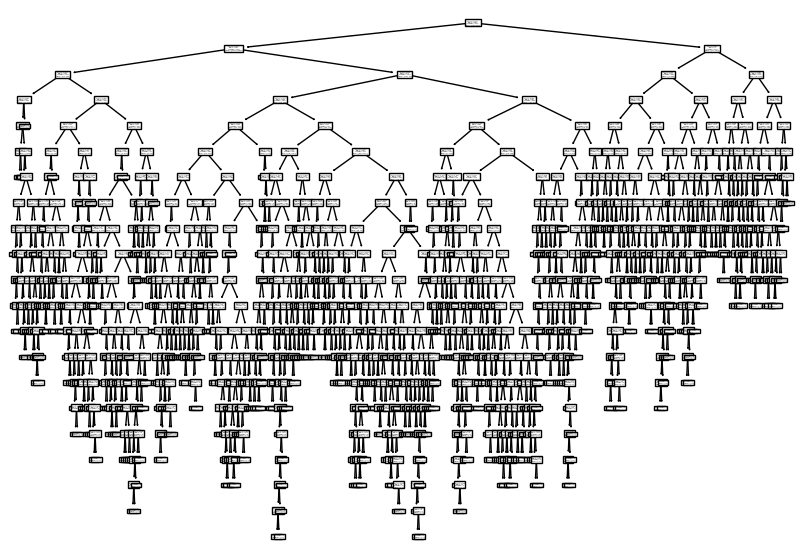

In [8]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(10,7))
plot_tree(dt)
plt.show()

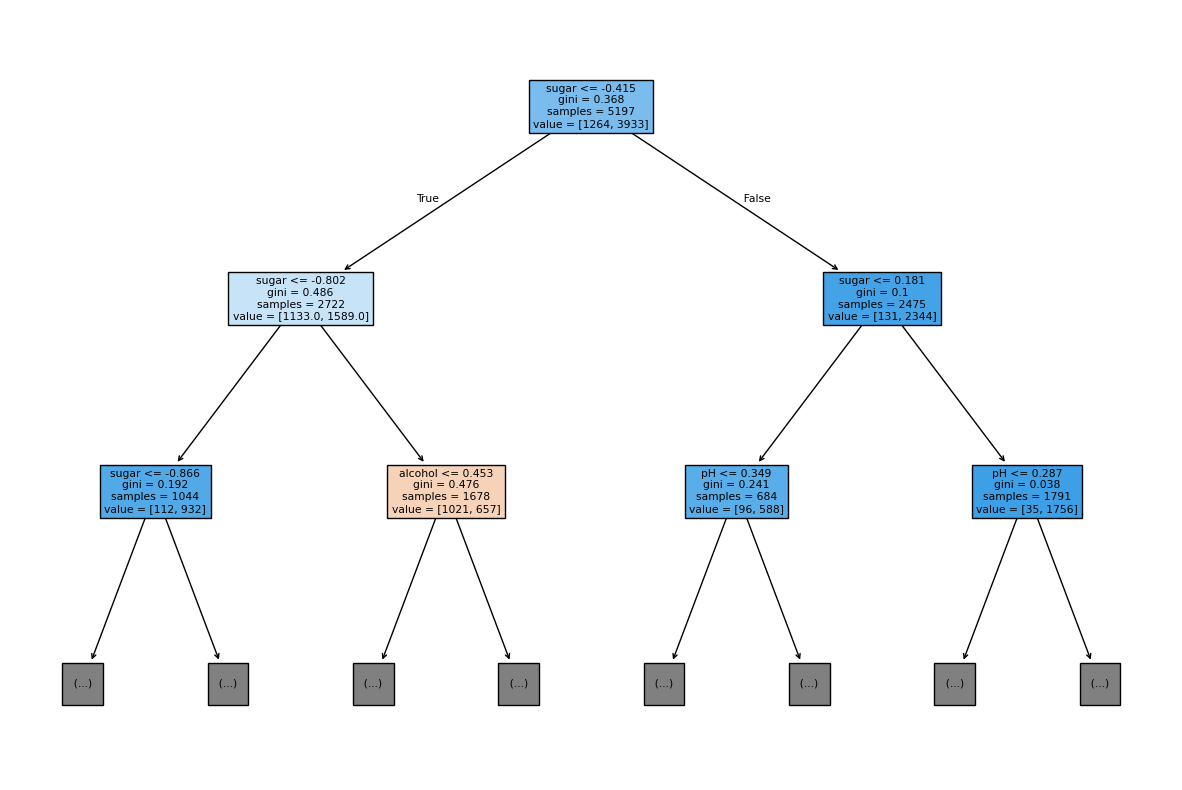

In [9]:
# 맨 위 노드가 깊이 0, 그밑으로 1,2,....
plt.figure(figsize=(15,10))
plot_tree(dt, max_depth=2, filled=True, feature_names=['alcohol','sugar','pH']) #max_depth=2는 2+1개까지 보여줌, filled=True는 노드에 색칠하기
plt.show()    #feature_names를 지정해줌으로써 어떤 특징에 대한 질문인지 볼 수 있음

## 해석 
- 루트노드의 총 샘플수는 5197, 이중 정답이 0(음성-레드와인)인 개수는 1264, 양성은 3933
- 그 밑의 왼쪽 노드: 2722개가 여기로 왔으며 이중 양성이 1589로 많이 줄음 ->이는 오른쪽 노드를 보면 2475개 중 2344가 양성인 것을 알수있음->첫번째 질문에서 양성이 많이 걸려졌다는 것을 의미
- filled=True에 의해 음성이 많으면 주항색 vs 양성이 많으면 푸른색이 됨
- 최종결정 방법: 맨 밑의 리프노드에서 대다수가 차지하고 있는 클래스가 해당 노드 전체 데이터의 클래스가 됨

## 지니(gini)=불순도
- 결정트리 함수의 criterion옵션의 기본 디폴트가 gini: 노드에서 어떤 기준으로 분할할지 이 지니불순도를 사용
- 지니불순도=1-(음성클래스비율^2 + 양성클래스비율^2)
- 루트노드로 예시) gini=1-[(1264/5197)^2=(3933/5197)^2] =0.368
- 반약 비율 반반이면 gini=0.5(최대값=최악), 하나의 클래스만 존재하면 gini=0(순수노드라 부름)
### 그렇다면 분할기준은?->부모노드와 자식노드의 불순도 차이(정보이득:information gain)가 가능한 크도록 기준 잡음
- 불순도 차이가 크다는 것은 자식노드의 불순도가 작다-> 최대한 정확하게 클래스가 나눠질 수 있도록 기준을 잡는다는것을 의미
- 불순도차이=부모gini - (왼쪽노드샘플수/부모샘플수) X 왼쪽노드gini - (오른쪽노드샘플수/부모샘플수) X 오른쪽노드gini =

In [10]:
0.368-(2722/5197)*0.486-(2475/5197)*0.1

0.06582720800461807

## 지니불순도 외에도 criterion='entropy'엔트로피 불순도도 사용가능
- 지니처럼 제곱이 아닌 밑이 2인 로그를 사용
- 결정트리학습때 지니와 그리 큰 차이 없음

# 1-2.가지치기
- 테스트 세트 점수가 낮은 이유는 트리가 제한없이 자라났기 때문->가지치기가 필요
- 무작정 끝까지 자라는 트리는 훈련세트에 아주 잘 맞겠지만 일반화가 잘 안돼 테스트세트 정확도는 낮아짐
### max_depth를 정해 학습시킴

In [11]:
dt=DecisionTreeClassifier(max_depth=3, random_state=123)   #깊이 0부터 3까지
dt.fit(train_data_scaled,train_answer)
dt.score(train_data_scaled,train_answer), dt.score(test_data_scaled,test_answer) #성능은 낮아졌지만 과대적합 문제는 해소

(0.8502982489898018, 0.8469230769230769)

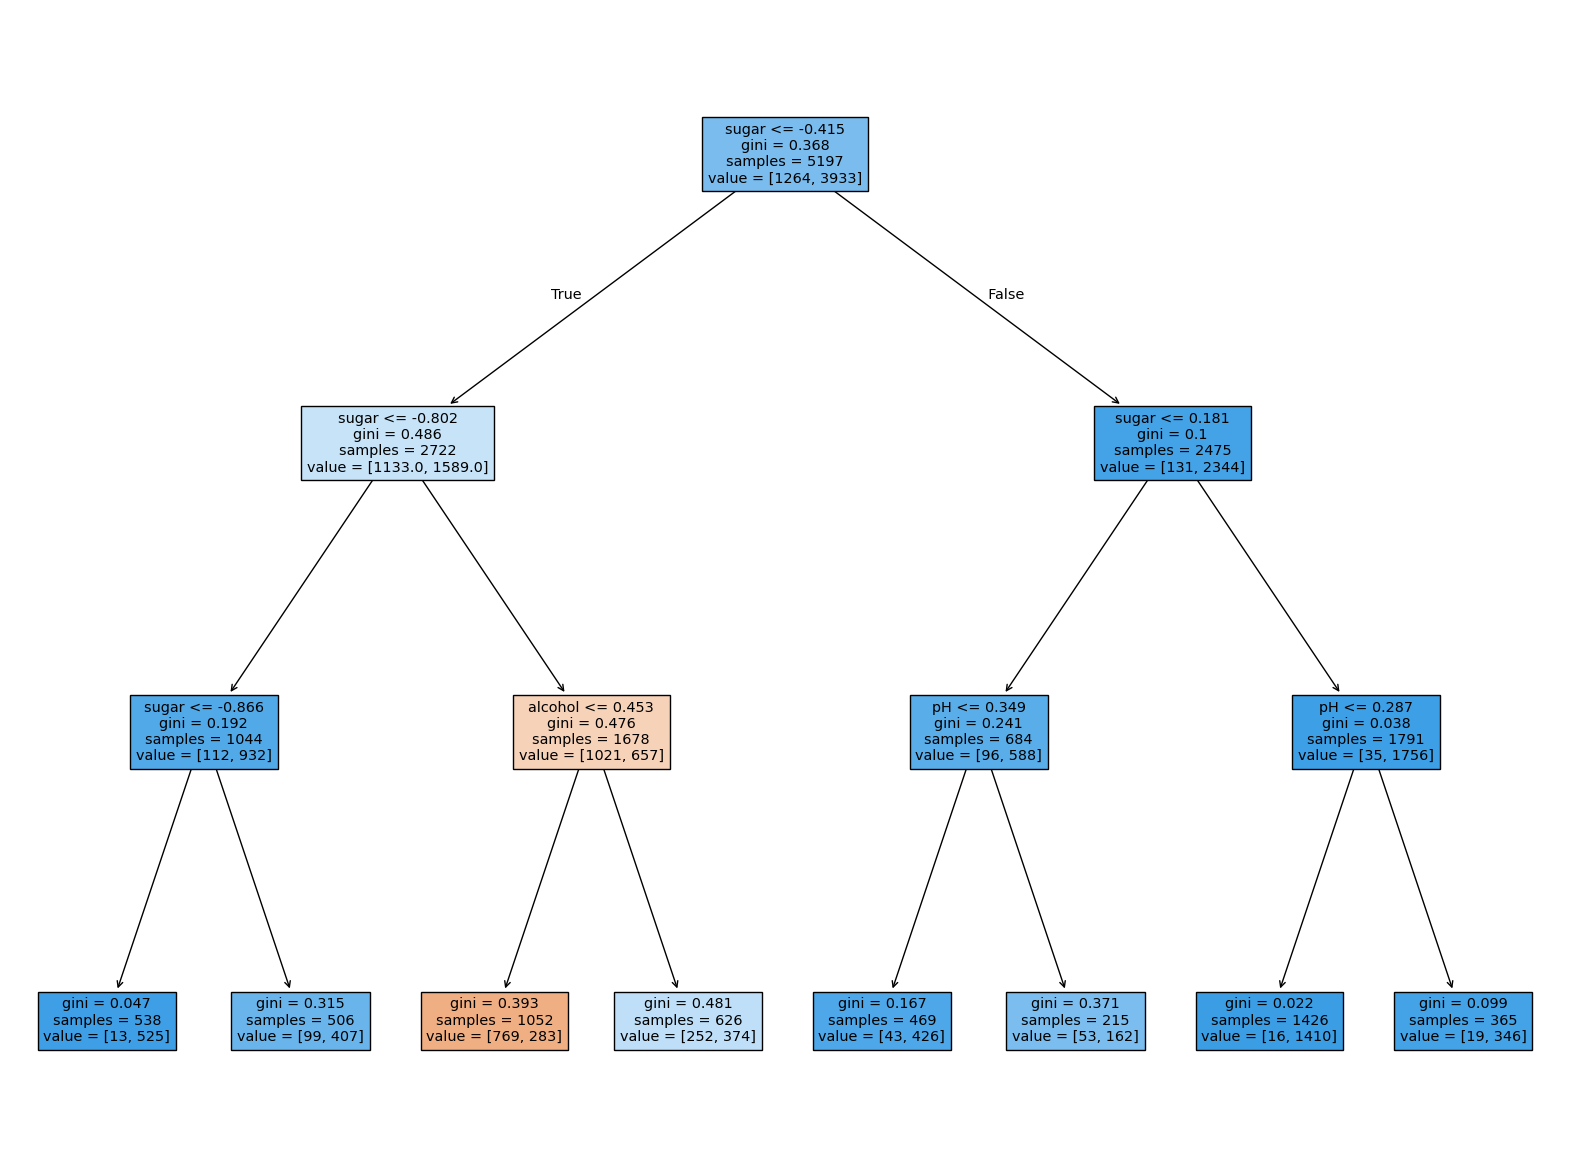

In [12]:
plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=['alcohol','sugar','pH']) #max_depth=2는 2+1개까지 보여줌, filled=True는 노드에 색칠하기
plt.show() 

## 어떤 노드는 sugar로, 어떤 노드는 알콜이나 pH로 기준잡는것을 볼 수 있음
## 해석: 리프노드 중 주항색노드에 도착한 샘플들만 레드와인으로 예측
## 그런데 비교기준중에 당도가 -값보다 작다는 있을수 없는일->표준화때문에 일어난 일
## 그런데 분할기준이 되는 지니불순도차이에서 이 값은 클래스별 비율을 가지고 계산했었음 

# 따라서 결정트리는 표준화 처리를 할 필요가 없다

In [13]:
dt=DecisionTreeClassifier(max_depth=3, random_state=123)   
dt.fit(train_data,train_answer)
dt.score(train_data,train_answer), dt.score(test_data,test_answer) #같은 값 나옴

(0.8502982489898018, 0.8469230769230769)

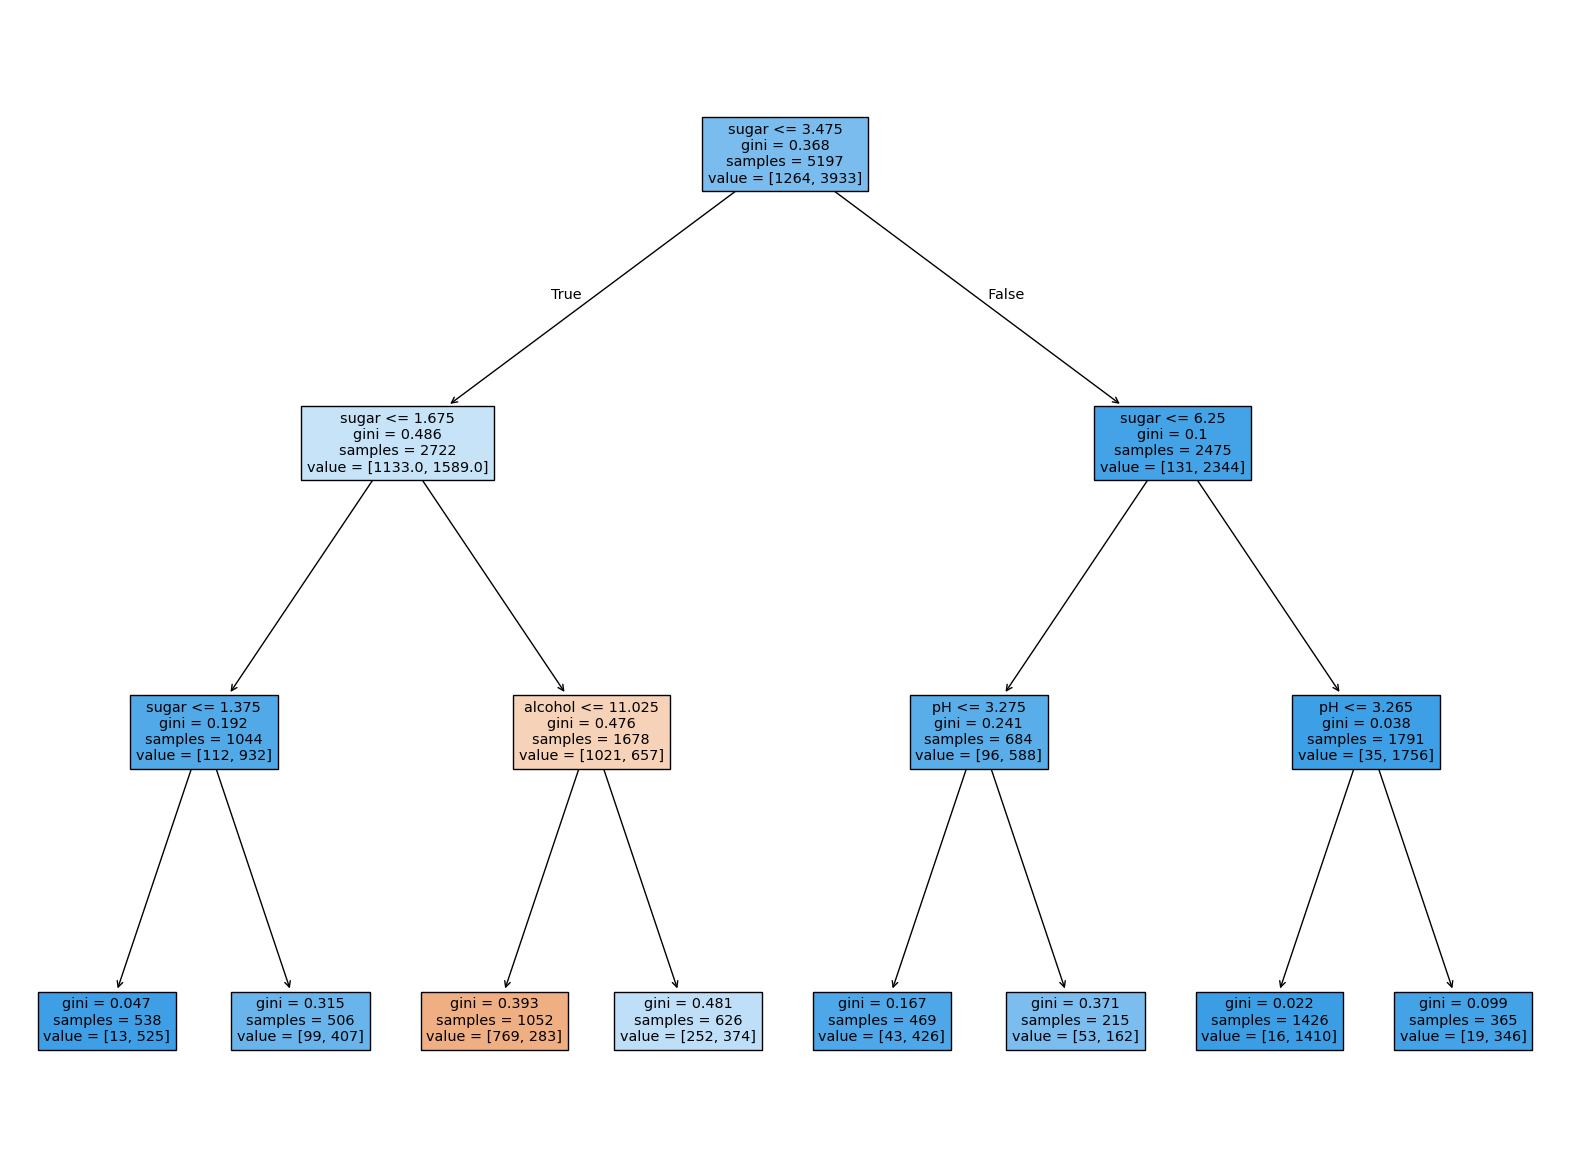

In [14]:
plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=['alcohol','sugar','pH']) 
plt.show() 

In [15]:
dt.feature_importances_  #알콜, 당도, pH중 당도가 class를 예측하는데 가장 큰 요인이 됨->가중치가 가장 크며 예측해나가면서 이 값을 더해가며 계산 

array([0.10744503, 0.88235605, 0.01019892])

# 2. 교차검증과 그리드 서치
### 그렇다면 max_depth는 어떻게 결정할까?->검증세트를 이용

# 2-1. 검증세트
- 테스트 세트는 최종모델을 선택하기 전까지 이용하지않고 검증세트를 이용해서 과대/과소적합을 판단
- 전체 데이터에서 훈련세트60%-검증세트20%-테스트세트20%

In [16]:
data=wine.iloc[:,:3].to_numpy()
answer=wine.iloc[:,3].to_numpy()

train_data, test_data, train_answer, test_answer=train_test_split(data,answer,test_size=0.2,random_state=1234)

In [17]:
# train세트에서 따로 또 검증세트 만듬
train_subdata, validation_subdata, train_subanswer, validation_subanswer=train_test_split(train_data,train_answer,test_size=0.2,random_state=1234) 
train_subdata.shape, validation_subdata.shape

((4157, 3), (1040, 3))

In [18]:
# 학습 후 트레인세트와 검증세트
dt=DecisionTreeClassifier(random_state=123)   
dt.fit(train_subdata,train_subanswer)
dt.score(train_subdata,train_subanswer), dt.score(validation_subdata,validation_subanswer)

(0.9983160933365408, 0.875)

# 2-2. 교차검증
- 전체 데이터에서 검증데이터를 다양하게 떼어내어 나머지를 학습시키고 검증데이터로 모델평가(dt.score)
- 그리고 이 값들을 평균내어 최종 검증 점수를 얻음
- 주로 5-폴드, 10-폴드 교차검증을 많이 사용

## cross_validate사용

In [19]:
from sklearn.model_selection import cross_validate
scores=cross_validate(dt,train_data,train_answer)   #모델객체를 넣고 뒤에는 검증세트 나눌필요없이 전체 훈련데이터 넣음
scores    #디폴트가 5-폴드여서 5번 수행->마지막의 test_score를 평균내어 최종 검증점수를 얻음 

{'fit_time': array([0.00797415, 0.0069766 , 0.00697589, 0.00598073, 0.00597858]),
 'score_time': array([0.00099635, 0.00199389, 0.00099635, 0.00100136, 0.0009973 ]),
 'test_score': array([0.83365385, 0.86538462, 0.87102984, 0.85755534, 0.86236766])}

In [20]:
import numpy as np
np.mean(scores['test_score'])

0.8579982601613978

## 분할기->교차검증할때 훈련세트섞기+폴드를 어떻게 나눌지 결정
- StratifiedKFold사용

In [21]:
from sklearn.model_selection import StratifiedKFold

splitter=StratifiedKFold(n_splits=10, shuffle=True, random_state=123)  #10-폴드교차검증 + 섞기
scores=cross_validate(dt,train_data,train_answer,cv=splitter) #cv(cross-validation)에 넣음
np.mean(scores['test_score'])

0.8687731584407885

# 2-3. 그리드 서치(grid search)
## 그리드 서치는 최적의 하이퍼파라미터 값을 알려주고 교차검증을 같이 동시에 수행!!!!
### 하이퍼파라미터: 모델이 학습할 수 없어서 사람이 직접 지정해야하는 파라미터(max_depth처럼)  
결정트리의 하이퍼파라미터:
- max_depth
- min_impurity_decrease(노드 분할 시 불순도가 최소한 얼마나 줄어야 분할을 수행할지)
- min_samples_split(노드를 분할하기 위한 최소 샘플 수)

In [22]:
from sklearn.model_selection import GridSearchCV

# 파라미터 직접 설정
params={'min_impurity_decrease':[0.0001,0.0002,0.0003,0.0004,0.0005]} #이 안의 값을 다 확인해보겠다

#객체 만들기-그리트서치에 확인할 모델과 파라미터정보, n_jobs(사용할 cpu코어수)-> -1이면 모든 코어 사용
gs=GridSearchCV(DecisionTreeClassifier(random_state=123),params,n_jobs=-1)  # cv의 디폴트는5->5폴드 수행하겠다->결국 각 파라미터당 5번 수행->5X5=25번 수행

#그리드 서치 수행
gs.fit(train_data,train_answer)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=123), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

## 최적의 하이퍼파라미터는 gs.best_estimator에 저장->얘를 직접 사용 가능

In [23]:
dt=gs.best_estimator_
dt.score(train_data,train_answer)

0.8947469694054262

In [24]:
dt.predict([[9.4,1.9,3.51]])  #->레드와인

array([0.])

### 최적의 매개변수는 gs.best_params_에 저장

In [25]:
gs.best_params_

{'min_impurity_decrease': 0.0004}

### 각 하이퍼파라미터별 교차검증 편균점수는 gs.cv_results_['mean_test_score']에 저장

In [26]:
gs.cv_results_['mean_test_score']  #->0.0004에서 가장 크다

array([0.86319131, 0.86319057, 0.86300085, 0.86646443, 0.86434626])

In [27]:
gs.cv_results_['params']  # 각 인덱스별 값

[{'min_impurity_decrease': 0.0001},
 {'min_impurity_decrease': 0.0002},
 {'min_impurity_decrease': 0.0003},
 {'min_impurity_decrease': 0.0004},
 {'min_impurity_decrease': 0.0005}]

In [28]:
best_index=np.argmax(gs.cv_results_['mean_test_score'])  #argmax로 최대값의 인덱스가져옴
gs.cv_results_['params'][best_index]

{'min_impurity_decrease': 0.0004}

# 모든 하이퍼파라미터 지정해서 최적값 보기

In [29]:
# 각 하이퍼파라미터 개수 동일핳 필요X
params={'min_impurity_decrease':np.arange(0.0001,0.001,0.0001),
       'max_depth':range(5,20,1),
       'min_samples_split':range(2,100,10)}  #9 X 15 X 10 X5(폴드)->6750모델수가 만들어짐

In [30]:
gs=GridSearchCV(DecisionTreeClassifier(random_state=123),params,n_jobs=-1)
gs.fit(train_data,train_answer)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=123), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [31]:
gs.best_params_

{'max_depth': 7, 'min_impurity_decrease': 0.0004, 'min_samples_split': 62}

In [32]:
np.max(gs.cv_results_['mean_test_score'])

0.8678100244317761

In [33]:
dt=gs.best_estimator_
dt.score(train_data,train_answer),dt.score(train_subdata,train_subanswer)

(0.8787762170482971, 0.876112581188357)

In [34]:
dt.predict([[9.4,1.9,3.51]])

array([0.])

# 2-4. 랜덤서치
- RandomizedSeachCV사용
- 하이퍼파라미터 값이나 간격을 지정하기 어려울경우 사용
- 매개변수에 값이 아닌 확률분포를 전달

### randint(정수)와 uniform(실수): 주어진 범위에서 고르게 뽑음

In [40]:
from scipy.stats import randint, uniform

#범위지정
rgen=randint(0,10)  #0~10사이 값
ugen=uniform(0,1)  #실수를 뽑음

#개수지정
rgen.rvs(20), ugen.rvs(20)   #20개뽑기

(array([2, 1, 7, 3, 0, 8, 3, 2, 2, 2, 1, 0, 3, 4, 1, 3, 1, 7, 4, 7],
       dtype=int64),
 array([0.22155847, 0.98077802, 0.53962931, 0.59632349, 0.94342817,
        0.88604143, 0.44404682, 0.21130611, 0.41100222, 0.7867062 ,
        0.71289354, 0.76475978, 0.89732481, 0.29874603, 0.77827574,
        0.83241512, 0.75599516, 0.93258717, 0.9340753 , 0.16515181]))

In [36]:
np.unique(rgen.rvs(1000),return_counts=True)  #고르게 추출 된것을 볼 수 있음

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([ 96, 110,  99, 100, 119,  84,  89,  96, 104, 103], dtype=int64))

In [39]:
uniform(0.0001,0.001)

## 하이퍼파라미터지정(개수는 필요X)
- RandomizedSeachCV의 n_iter에서 개수 정하고 그 수만큼 랜덤하게 뽑음

In [42]:
params={'min_impurity_decrease':uniform(0.0001,0.001),
       'max_depth':randint(20,50),
       'min_samples_split':randint(2,25),
       'min_samples_leaf':randint(1,25)}

In [43]:
from sklearn.model_selection import RandomizedSearchCV

gs=RandomizedSearchCV(DecisionTreeClassifier(random_state=123),params,n_iter=100,n_jobs=-1,random_state=123) #n_iter가 개수
gs.fit(train_data,train_answer)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=123),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AA23D34770>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002AA24643C50>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AA23D35400>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AA23D35100>},
                   random_state=123)

In [45]:
gs.best_params_, np.max(gs.cv_results_['mean_test_score'])

({'max_depth': 26,
  'min_impurity_decrease': 0.0006395048225537354,
  'min_samples_leaf': 2,
  'min_samples_split': 5},
 0.8670400533056932)

In [46]:
dt=gs.best_estimator_
dt.score(train_data,train_answer), dt.score(test_data,test_answer)

(0.8845487781412353, 0.8615384615384616)

# 3. 트리의 앙상블(ensemble-조화)
- 앙상블학습: 정형데이터를 다루는데 가장 뛰어난 성과를 내는 알고리즘
- 정형데이터: 데이터프레임으로 된 데이터
- 비정형데이터: 표현하기 어려움 ex) 텍스트, 사진, 음성-> 주로 신경망 알고리즘 사용

# 3-1. 랜덤포레스트
- 앙상블 학습의 대표주자이며 널리 사용
- 랜덤포레스트: 다양하고 랜덤한 결정트리를 모아 숲으로 만든것(결정트리와 같은 하이퍼파라미터사용)
- 각 결정트리마다 랜덤하게 훈련데이터 추출(중복가능)+ 훈련데이터 총 개수만큼 뽑음->이를 부트스트랩 샘플이라 부름
- 이 각 부트스트랩 샘플들로 결정트리 모델을 돌림
- 또한 각 노드는 전체특성(컬럼)중 제곱근개수(9개라면 3개 선택)의 특성을 분할 기준으로 함
- 마지막으로 각 트리의 클래스별 확률들을 평균하여 가장 높은 확률을 가진 클래스를 예측으로 삼음
### 결국 랜덤하게 선택한 샘플과 특성을 사용해 훈련세트의 과대적합을 막고 좋은 성능을 얻을 수 있게 해줌

In [49]:
data.shape, answer.shape

((6497, 3), (6497,))

In [50]:
train_data, test_data, train_answer, test_answer=train_test_split(data,answer,test_size=0.2,random_state=1234)
train_data.shape, test_data.shape

((5197, 3), (1300, 3))

## 우선 교차검증

In [51]:
from sklearn.ensemble import RandomForestClassifier

#객체 생성
rf=RandomForestClassifier(n_jobs=-1,random_state=123)  #기본적으로 100개의 결정트리 사용

#교차검증
scores=cross_validate(rf, train_data, train_answer,
                     return_train_score=True, n_jobs=-1)  #return_train_score=True->검증점수뿐만아니라 훈련세트 점수도 같이 반환
scores  #다소 과대적합 but 이 예제는 간단하고 특성이 많지 않아 그리드서치를 통한 파라미터 최적화해도 별 차이는 없을것

{'fit_time': array([0.24774003, 0.24973631, 0.27880454, 0.24873924, 0.24973297]),
 'score_time': array([0.02807522, 0.02906895, 0.05462575, 0.02906895, 0.02807522]),
 'test_score': array([0.88269231, 0.89711538, 0.89220404, 0.88835419, 0.89412897]),
 'train_score': array([0.99855665, 0.99735386, 0.998076  , 0.9978355 , 0.998076  ])}

## 특성 중요도
- 결정트리([0.10744503, 0.88235605, 0.01019892])와 달리 특성에 대한 중요도가 고르게 분포
- ->랜덤포레스트가 특성을 랜덤하게 뽑았기 때문

In [52]:
rf.fit(train_data,train_answer)
rf.feature_importances_

array([0.23359739, 0.49380185, 0.27260076])

### 부트스트랩에 포함되지 않은 데이터(OOB)를 검증세트로써 사용하는 기능도 존재

In [53]:
rf=RandomForestClassifier(oob_score=True, n_jobs=-1,random_state=123) #oob_score를 True로 하여 oob사용
rf.fit(train_data,train_answer)
rf.oob_score_  #남은 데이터의 score값

0.8968635751395035

# 3-2. 엑스트라 트리
- 랜덤포레스트와 비슷하지만
- 차이점: 부트스트랩이 아닌 전체 샘플사용, 노드에서 가장 좋은 분할을 찾는것이 아닌 무작위로 분할
- 성능이 낮아지지만 과대적합을 막고 검증세트의 점수를 높이는 효과가 있음
- 특성이 랜덤이므로 더 많은 결정트리가 필요하지만 랜덤분할덕에 속도는 빠름

In [55]:
from sklearn.ensemble import ExtraTreesClassifier

et=ExtraTreesClassifier(n_jobs=-1,random_state=123)
scores=cross_validate(et,train_data,train_answer, return_train_score=True, n_jobs=-1)
np.mean(scores['train_score']), np.mean(scores['test_score'])

(0.9980277128942033, 0.8837824831568817)

In [56]:
et.fit(train_data,train_answer)
et.feature_importances_

array([0.20098528, 0.51295716, 0.28605756])

# 3-3. 그레디언트 부스팅(Gradient boosting)
- 앙상블 방식 중 깊이가 얕은 결정트리를 사용하여 이전 트리의 오차를 보완하는 방식
- 주로 깊이3인 결정트리 100개사용->과대적합을 예방하고 일반화에 좋음
- 경사하강법과 유사: 결정트리를 계속 추가해 가면서 가장 낮은곳으로 이동하는 방식

In [57]:
from sklearn.ensemble import GradientBoostingClassifier

gb=GradientBoostingClassifier(random_state=123)
scores=cross_validate(gb,train_data,train_answer, return_train_score=True, n_jobs=-1)
np.mean(scores['train_score']), np.mean(scores['test_score'])  #매우 정확하지는 않지만 과대적합은 억제

(0.8869060723041959, 0.8706959354408825)

In [58]:
# 결정트리 100->500개로 늘리고 학습은 0.1->0.2로
gb=GradientBoostingClassifier(n_estimators=500,learning_rate=0.2,random_state=123)
scores=cross_validate(gb,train_data,train_answer, return_train_score=True, n_jobs=-1)
np.mean(scores['train_score']), np.mean(scores['test_score'])  #트레이닝세트의 정확도는 올라감

(0.9428035350816202, 0.876662286221959)

## 일부 특성에 더 집중

In [59]:
gb.fit(train_data,train_answer)
gb.feature_importances_  #당도에 더 집중

array([0.16767094, 0.66197006, 0.17035899])

# 3-4. 히스토그램 기반 그레디언트 부스팅
- 정형데이터 다루는 머신러닝 알고리즘 중 가장 인기가 높음
- 미리 입력받은 특정을 256개의 구간으로 나눔->노드 분할때 최적의 분할을 빠르게 찾을 수 있음
- 트리 개수 지정하는데 n_estimators대신 max_iteer(반복횟수) 사용

In [60]:
from sklearn.experimental import enable_hist_gradient_boosting  #hgb이용할려면 얘 미리 임포트필요
from sklearn.ensemble import HistGradientBoostingClassifier

hgb=HistGradientBoostingClassifier(random_state=123)
scores=cross_validate(hgb, train_data,train_answer, return_train_score=True)
np.mean(scores['train_score']), np.mean(scores['test_score'])  #과대적합 억제하면서 그냥 그레디언트보다 더 높은 성능

C:\anaconda3\Lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


(0.9333752892569347, 0.8801245650403494)

## 특성 중요도
- hgb는 permutation_importance()사용
- 특성을 하나씩 랜덤하게 섞어서 모델 성능변화를 통해 중요도 측정

In [62]:
from sklearn.inspection import permutation_importance

hgb.fit(train_data,train_answer)
result=permutation_importance(hgb,train_data,train_answer,
                             n_repeats=10, random_state=123, n_jobs=-1) #n_repeats는 랜덤하게 섞을 횟수/원래 디폴트값은 5
result.importances_mean   #각 특성 중요도가 랜덤포레스트와 비슷(당도중요도=0.239)

array([0.09528574, 0.23948432, 0.08537618])

In [63]:
hgb.score(test_data,test_answer)  #최근 모델이기도 하며 정확도도 나쁘진 않음

0.8730769230769231

# 3-5. 그 외 라이브러리에서의 그레디언트 부스팅

In [66]:
from xgboost import XGBClassifier

xgb=XGBClassifier(tree_method='hist', random_state=123)
score=cross_validate(xgb,train_data,train_answer,return_train_score=True)
np.mean(scores['train_score']), np.mean(scores['test_score']) 

(0.9333752892569347, 0.8801245650403494)

In [68]:
from lightgbm import LGBMClassifier

lgb=LGBMClassifier(random_state=123)
scores=cross_validate(lgb,train_data,train_answer,return_train_score=True,n_jobs=-1)
np.mean(scores['train_score']), np.mean(scores['test_score']) 

(0.9341931520666185, 0.8789710890649293)

# 4. 랜덤포레스트로 다중 클래스 분류
- 여러 클래스들은 라벨 인코딩이나 원 핫 인코딩이 되어있어야함

In [76]:
from sklearn.datasets import load_iris

# 예시 데이터셋: Iris dataset (세 가지 종류의 꽃)
data = load_iris()
X = data.data
y = data.target

X[:10,:],np.unique(y)   #이미 종은 라벨 인코딩 되어있음->0:setosa, 1:versicolor, 2:virginica

(array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1]]),
 array([0, 1, 2]))

In [79]:
# 훈련 데이터와 테스트 데이터로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 랜덤 포레스트 모델 생성
rf = RandomForestClassifier(n_estimators=100,max_depth=10, random_state=42)

# 모델 학습
rf.fit(X_train, y_train)

rf.score(X_train,y_train), rf.score(X_test,y_test)   #간단한 데이터셋이여서 정확도 높게 나옴

(1.0, 1.0)

In [72]:
rf.predict(X_test) #예측

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0,
       0])